# U-Net CNN: Image Segmentation

In the notebook below, we will be building a Convolutional Neural Network with a U-Net architecture in order to perform an image segmentation task. In particular, we will be identifying and segmenting the left ventricle of the heart within a data set of cine-MRI cardiac images. We will train our CNN on a set of expert-drawn contours and then generate contours of our own on a never-before-seen dataset. Finally, we will visualize and compare our predicted contours to the ground-truth values.

**Note:** You can greatly improve the computation speed in Google Colab by connecting to a GPU. Click the "Runtime" tab in the top ribbon, then "Change runtime type". You can then select "T4 GPU". Note, however, that GPUs are subject to availability; Google has a fixed (and unspecified) amount of resources available at any given time, so a GPU may not be available. Feel free to try again later if you don't succeed at first.

# Libraries to Import

In [ ]:
!pip install tensorflow==2.18.0
!pip install keras==3.8.0
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import random
import tensorflow as tf
import json

**Real quick**: make sure tensorflow and keras are version 2.18.0 and 3.8.0, respectively by running the cells below.

If either is showing the wrong version, restart the session by clicking the "Runtime" tab up top and selecting "Restart session". After that, run the notebook again from the top.

In [ ]:
!pip show tensorflow #Should be version 2.18.0

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [ ]:
!pip show keras #Should be version 3.8.0

Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [ ]:
#Run this cell but DO NOT EDIT

def set_random_seed():
  seed = 18
  # Set random seeds for reproducibility
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)


# Part 1: Loading and Visualizing Data

Because the image files for this assgiment are rather large, it is recommended you save them to your Google Drive and import them into the enviroment (dragging and dropping directly into Colab will work, but might take some time):


1.   Save the following files to your Google Drive (the same account you're using to complete this assigment) in an accessible location: `cardiac_img_train.pkl`, `cardiac_img_test.pkl`, `cardiac_img_val.pkl`, `cardiac_contour_train.pkl`, `cardiac_contour_test.pkl`, `cardiac_contour_val.pkl`.


In [ ]:
#Run this cell to mount your Google Drive (click through pop-up windows to authenticate)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_data(path):
  with open(path, 'rb') as f:
   data = pickle.load(f)
   data = np.array(data)
   return data

In [ ]:
base_path = "drive/MyDrive/EAS5860/Segmentation_Data"

In [ ]:
#Run this cell but DO NOT EDIT

x_train = get_data(os.path.join(base_path, "cardiac_img_train.pkl"))
x_test = get_data(os.path.join(base_path,"cardiac_img_test.pkl"))
x_val = get_data(os.path.join(base_path, "cardiac_img_val.pkl"))

y_train = get_data(os.path.join(base_path,"cardiac_contour_train.pkl"))
y_test = get_data(os.path.join(base_path,"cardiac_contour_test.pkl"))
y_val = get_data(os.path.join(base_path,"cardiac_contour_val.pkl"))

Now, that our data is loaded, let's do some exploration to see if we need to manipulate it for our CNN training purposes. In the cell below, consider exploring the following (this cell is ungraded, but will inform other graded portions of the assigment):


*   What are the dimensions of the images?
*   Are the images grayscale or RGB?
*   Do the pixel values need to be normalized?




In [ ]:
print(x_train[0].shape)
# greyscale images

print(x_train.min(), x_train.max())
# no need to normalize

(256, 256)
0.0 1.0


Now that we understand the data a bit better, **use matplotlib** to construct the following:


*   Create a `subplot` showing 3 things: the cardiac image at `x_train[0]`, the corresponding contour at `y_train[0]`, and a joint image of the contour superimposed on the cardiogram image.



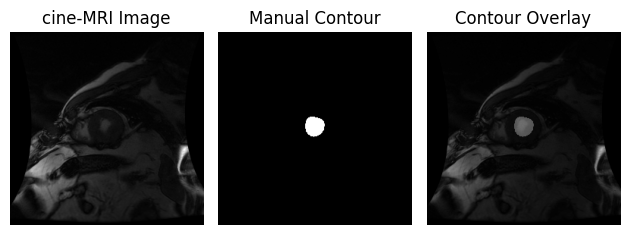

In [ ]:
image = x_train[0]
contour = y_train[0]

fig, axes = plt.subplots(1, 3)
axes[0].imshow(image, cmap='gray')
axes[0].set_title("cine-MRI Image")
axes[0].axis('off')

axes[1].imshow(contour, cmap='gray')
axes[1].set_title("Manual Contour")
axes[1].axis('off')

axes[2].imshow(image, cmap='gray')
axes[2].imshow(contour, cmap='gray', alpha=0.3)
axes[2].set_title("Contour Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.show()

As a final bit of data prep, make sure to reshape your `x` data such that it is of shape (|x|, `img_height`, `img_width`, `num_channels`), where `img_height` and `img_width` are the pixel dimensions of the images, and the `num_channels` indicates whether the image is grayscale or RGB.

In [ ]:
x_train = x_train.reshape((-1, 256, 256, 1))
x_val = x_val.reshape((-1, 256, 256, 1))
x_test = x_test.reshape((-1, 256, 256, 1))

# Part 2: Constructing the U-Net

Since constructing Neural Networks is as much an art as it is a science, it is often appropriate to begin with a tried and true network architecture and then modify the network to suit your unique use-case. In our case, we will be modifying the example [U-Net architecture available in the Keras documentation](https://keras.io/examples/vision/oxford_pets_image_segmentation/) to perform our segmenation task.

In [ ]:
set_random_seed()

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model((256, 256), 1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ activation_15[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6  │ (None, 128, 128,  │      2,400 │ activation_16[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_7  │ (None, 128, 128,  │      4,736 │ activation_17[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │      2,112 │ activation_15[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 64, 64,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 64, 64,    │          0 │ add_7[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_8  │ (None, 64, 64,    │      8,896 │ activation_18[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 2,057,825 (7.85 MB)

 Trainable params: 2,054,049 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

Now that the architecture is set, we will attempt to compile and fit our model. To do so, we will be using the DICE coefficient in our loss function to teach the model whether its predictions seem to match the ground truth.



In [ ]:
#Run this cell but DO NOT EDIT

def dice_coef(y_true, y_pred, smooth = 0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
num_epochs = 50
batch_size = 16

model.compile(optimizer='adam', loss= dice_coef_loss, metrics=['accuracy'])
model.fit(x = x_train, y = y_train, epochs=num_epochs, validation_data = (x_val, y_val), batch_size=batch_size)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 491ms/step - accuracy: 0.8048 - loss: 0.7058 - val_accuracy: 0.9607 - val_loss: 1.0000
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.9918 - loss: 0.2324 - val_accuracy: 0.9819 - val_loss: 1.0000
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9946 - loss: 0.1593 - val_accuracy: 0.9842 - val_loss: 1.0000
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9956 - loss: 0.1293 - val_accuracy: 0.9248 - val_loss: 1.0000
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9962 - loss: 0.1103 - val_accuracy: 0.9779 - val_loss: 1.0000
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9970 - loss: 0.0878 - val_accuracy: 0.9748 - val_loss: 1.0000
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9975 - loss: 0.0741 - val_accuracy: 0.9388 - val_loss: 1.0000
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9977 - loss: 0.0674 - val_accurac

# Part 3: Evaluate the U-Net

We will now generate predictions on our test data set. Again, the goal here is to achieve an average DICE score >= 0.82. If you do not achieve this, double check your input/output layers in the U-Net or consider increasing the number of epochs during training.

In [ ]:
#Run this cell but DO NOT EDIT

def avg_dice(y_test, y_pred):
  total = 0
  for i in range(len(y_test)):
    coef = dice_coef(y_test[i], y_pred[i])
    total += coef
  return float(np.squeeze(total/len(y_test)))


In [ ]:
#Run to observe average DICE Score

y_pred = model.predict(x_test)
binary_predictions = np.where(y_pred > 0.5, 1, 0)
score = avg_dice(y_test, y_pred)
print(f"Average DICE Score = {score}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Average DICE Score = 0.864278256893158


If you're pleased with your results, save your model

In [ ]:
path = "drive/MyDrive/EAS5860/HW6"

model.save(os.path.join(path, "EAS5860_HW6_Part_UNET.keras"))

# Part 4: Visualizing Predictions

Now that we have a numeric representation of our model's performance in the DICE score, let's move on to visualizing our predictions relative to the ground truth values.


*   Construct a function called `display_predictions()` which takes as arguments a cardiac image, the ground-truth contour, the predicted contour, and the index number of the image. Use the `binary_predictions` variable for the predicted contours.
*   The function should return a subplot showing the cardiac image alone, the ground-truth contour alone, the predicted contour alone, and an aggregate plot overlaying all three images. The plot should be a single row with four columns.


In [ ]:
def display_predictions(image, true_contour, predicted_contour, index_number):
  """
  Function to display a subplot of a cardiogram image, it's ground-truth contour, and the predicted contour.
  :param image: Image array from x_test
  :param true_contour: Contour array from y_test
  :param predicted_contour: Predicted contour array from binary_predictions
  :param index_number: Index number of x_test image
  """
  fig, axs = plt.subplots(1, 4)

  axs[0].imshow(image, cmap='gray')
  axs[0].set_title(f"cine-MRI Image {index_number}", fontsize=10)
  axs[0].axis('off')

  axs[1].imshow(true_contour, cmap='Greens', alpha=1.0)
  axs[1].set_title(f"Ground-Truth Contour {index_number}", fontsize=10)
  axs[1].axis('off')

  axs[2].imshow(predicted_contour, cmap='Reds', alpha=1.0)
  axs[2].set_title(f"Predicted Contour {index_number}", fontsize=10)
  axs[2].axis('off')

  axs[3].imshow(image, cmap='gray')
  axs[3].imshow(true_contour, cmap='Greens', alpha=0.3)
  axs[3].imshow(predicted_contour, cmap='Reds', alpha=0.3)
  axs[3].set_title(f"Aggregate Image {index_number}", fontsize=10)
  axs[3].axis('off')

  plt.tight_layout()
  plt.show()

With your `display_predictions()` function complete, explore the data by displaying different sets of images. Display at least 3 different sets of images in the cells below. (i.e. show the results for `display_predictions()` for three different indices of your choice)

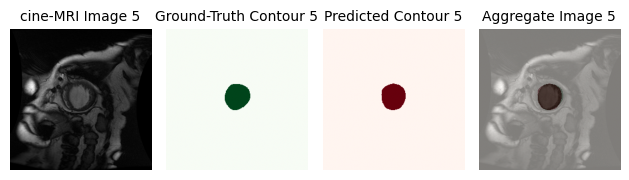

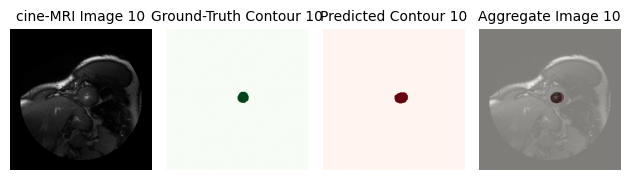

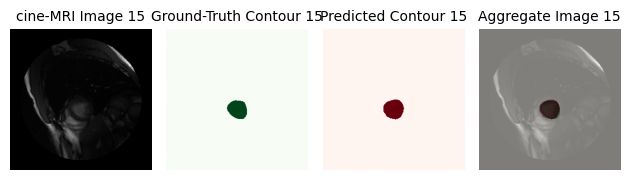

In [ ]:
inds = [5, 10, 15]
for i in inds:
  display_predictions(x_test[i], y_test[i], binary_predictions[i], i)

# Data Citation
Radau P, Lu Y, Connelly K, Paul G, Dick AJ, Wright GA. “Evaluation Framework for Algorithms Segmenting Short Axis Cardiac MRI.” The MIDAS Journal – Cardiac MR Left Ventricle Segmentation Challenge, http://hdl.handle.net/10380/3070